<a href="https://colab.research.google.com/github/ShreyPandit/Lipschitz/blob/master/Lipschitz_MNIST_RMSProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
from tqdm import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, BatchNormalization, MaxPool2D, Dropout
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tqdm import tqdm_notebook as tqdm

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
!pip install tensorflow==1.14.0

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [3]:
num_classes=10
batch_size = 256
epochs = 20
img_rows, img_cols = 28, 28
lrs=[]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 128)       

In [6]:
from keras import backend as K
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [8]:
lrs = []
K2 = 0.
beta2 = 0.9

In [19]:
def lr_schedule(epoch):
    global K2

    Kz = 0.  # max penultimate activation
    S = 0.
    
    sess = K.get_session()
    max_wt = 0.
    for weight in model.weights:
        norm = np.linalg.norm(weight.eval(sess))
        if norm > max_wt:
            max_wt = norm
    
    for i in tqdm(range((len(x_train) - 1) // batch_size + 1)):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
    	
        tmp = np.array(func([xb]))
        activ = np.linalg.norm(tmp)
        sq = np.linalg.norm(np.square(tmp))

        if sq > S:
            S = sq
        
        if activ > Kz:
            Kz = activ

    S_ = (num_classes - 1) ** 2 / (num_classes * batch_size) ** 2 * S + 2e-4 * max_wt * ((num_classes - 1) * Kz) / (num_classes * batch_size)
    
    K2 = beta2 * K2 + (1 - beta2) * S_

    lr = (np.sqrt(K2) + K.epsilon()) / Kz
    print('S =', S, 'max_wt =', max_wt, 'Kz =', Kz, 'K2 =', K2, 'S_ =', S_)
    lrs.append(lr)
    print('Epoch', epoch+1, 'LR =', lr)
    return lr

In [20]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [21]:
from keras.optimizers import RMSprop
optimizer = RMSprop(lr=1e-3, decay=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

datagen.fit(x_train)

In [23]:
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size,
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



S = 97.15463 max_wt = 15.938357 Kz = 88.62701 K2 = 0.0002194006764971453 S_ = 0.0021940067649714535
Epoch 1 LR = 0.00016713054614729428
235/234 [==============================] - 270s 1s/step - loss: 0.5597 - accuracy: 0.8215 - val_loss: 0.0756 - val_accuracy: 0.9775
Epoch 2/5



S = 2076.3916 max_wt = 16.10016 Kz = 426.98413 K2 = 0.0032471657479923033 S_ = 0.030497051391448732
Epoch 2 LR = 0.0001334569687258602
235/234 [==============================] - 269s 1s/step - loss: 0.1570 - accuracy: 0.9519 - val_loss: 0.0441 - val_accuracy: 0.9865
Epoch 3/5



S = 2605.515 max_wt = 16.25509 Kz = 484.35034 K2 = 0.006696347821061113 S_ = 0.03773898647868042
Epoch 3 LR = 0.0001689506714097309
235/234 [==============================] - 266s 1s/step - loss: 0.1200 - accuracy: 0.9625 - val_loss: 0.0345 - val_accuracy: 0.9883
Epoch 4/5



S = 2617.2964 max_wt = 16.44565 Kz = 479.45642 K2 = 0.009816003822234815 S_ = 0.03789290783279814
Epoch 4 LR = 0.0002066420295630016
235/234 [==============================] - 269s 1s/step - loss: 0.0950 - accuracy: 0.9712 - val_loss: 0.0314 - val_accuracy: 0.9899
Epoch 5/5



S = 2599.002 max_wt = 16.68012 Kz = 483.8217 K2 = 0.012614107087685643 S_ = 0.03779703647674309
Epoch 5 LR = 0.00023213643638945094
235/234 [==============================] - 269s 1s/step - loss: 0.0764 - accuracy: 0.9757 - val_loss: 0.0341 - val_accuracy: 0.9887


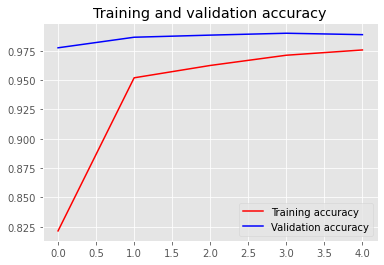

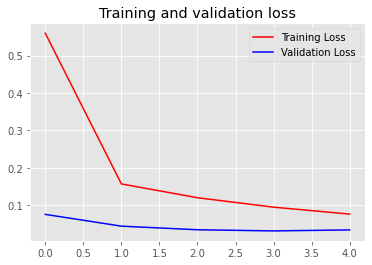

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()